# Evolver Loop 3 Analysis

## Current Status
- Best CV: 84.894026 (exp_002 - ensemble approach)
- Best LB: 117.281454 (exp_001 - not yet submitted exp_002)
- Target: 68.931058
- Gap: 15.96 points (23.2%)

## Key Questions
1. Which N values contribute most to the score?
2. What optimization techniques haven't we tried?
3. How can we close the remaining 15.96 point gap?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the best submission
df = pd.read_csv('/home/submission/submission.csv')

# Fast scoring function
TX = np.array([0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125])
TY = np.array([0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5])

def strip_s(val):
    s = str(val)
    return float(s[1:] if s.startswith('s') else s)

def score_group_fast(xs, ys, degs):
    n = len(xs)
    if n == 0:
        return float('inf'), 0
    
    all_x = []
    all_y = []
    
    for i in range(n):
        rad = np.radians(degs[i])
        c, s = np.cos(rad), np.sin(rad)
        px = TX * c - TY * s + xs[i]
        py = TX * s + TY * c + ys[i]
        all_x.extend(px)
        all_y.extend(py)
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    
    side = max(all_x.max() - all_x.min(), all_y.max() - all_y.min())
    return side * side / n, side

print('Loaded submission with', len(df), 'rows')

Loaded submission with 20100 rows


In [2]:
# Analyze score contribution by N
df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)
df['x_val'] = df['x'].apply(strip_s)
df['y_val'] = df['y'].apply(strip_s)
df['deg_val'] = df['deg'].apply(strip_s)

scores = []
for n in range(1, 201):
    group = df[df['N'] == n]
    xs = group['x_val'].values
    ys = group['y_val'].values
    degs = group['deg_val'].values
    score, side = score_group_fast(xs, ys, degs)
    scores.append({'N': n, 'score': score, 'side': side, 'contribution_pct': score / 84.894026 * 100})

scores_df = pd.DataFrame(scores)
total_score = scores_df['score'].sum()
print(f'Total score: {total_score:.6f}')
print(f'Target: 68.931058')
print(f'Gap: {total_score - 68.931058:.6f} ({(total_score - 68.931058) / 68.931058 * 100:.2f}%)')

Total score: 84.894026
Target: 68.931058
Gap: 15.962968 (23.16%)


In [3]:
# Top 20 worst-performing N values (highest score contribution)
worst_n = scores_df.nlargest(20, 'score')
print('Top 20 worst-performing N values:')
print(worst_n.to_string(index=False))
print(f'\nThese 20 N values contribute {worst_n["score"].sum():.4f} ({worst_n["score"].sum() / total_score * 100:.2f}%) of total score')

Top 20 worst-performing N values:
 N    score     side  contribution_pct
 1 0.661250 0.813173          0.778912
19 0.492130 3.057855          0.579700
49 0.490000 4.900000          0.577190
21 0.487619 3.200000          0.574386
31 0.482449 3.867290          0.568296
20 0.480849 3.101126          0.566411
50 0.480200 4.900000          0.565646
37 0.476757 4.200000          0.561590
25 0.472148 3.435651          0.556162
53 0.471698 5.000000          0.555632
26 0.471154 3.500000          0.554991
51 0.470784 4.900000          0.554555
34 0.470588 4.000000          0.554324
32 0.468214 3.870770          0.551528
76 0.465822 5.950000          0.548710
22 0.465455 3.200000          0.548277
38 0.464211 4.200000          0.546812
54 0.462963 5.000000          0.545342
52 0.461731 4.900000          0.543891
28 0.460505 3.590841          0.542447

These 20 N values contribute 9.6565 (11.37%) of total score


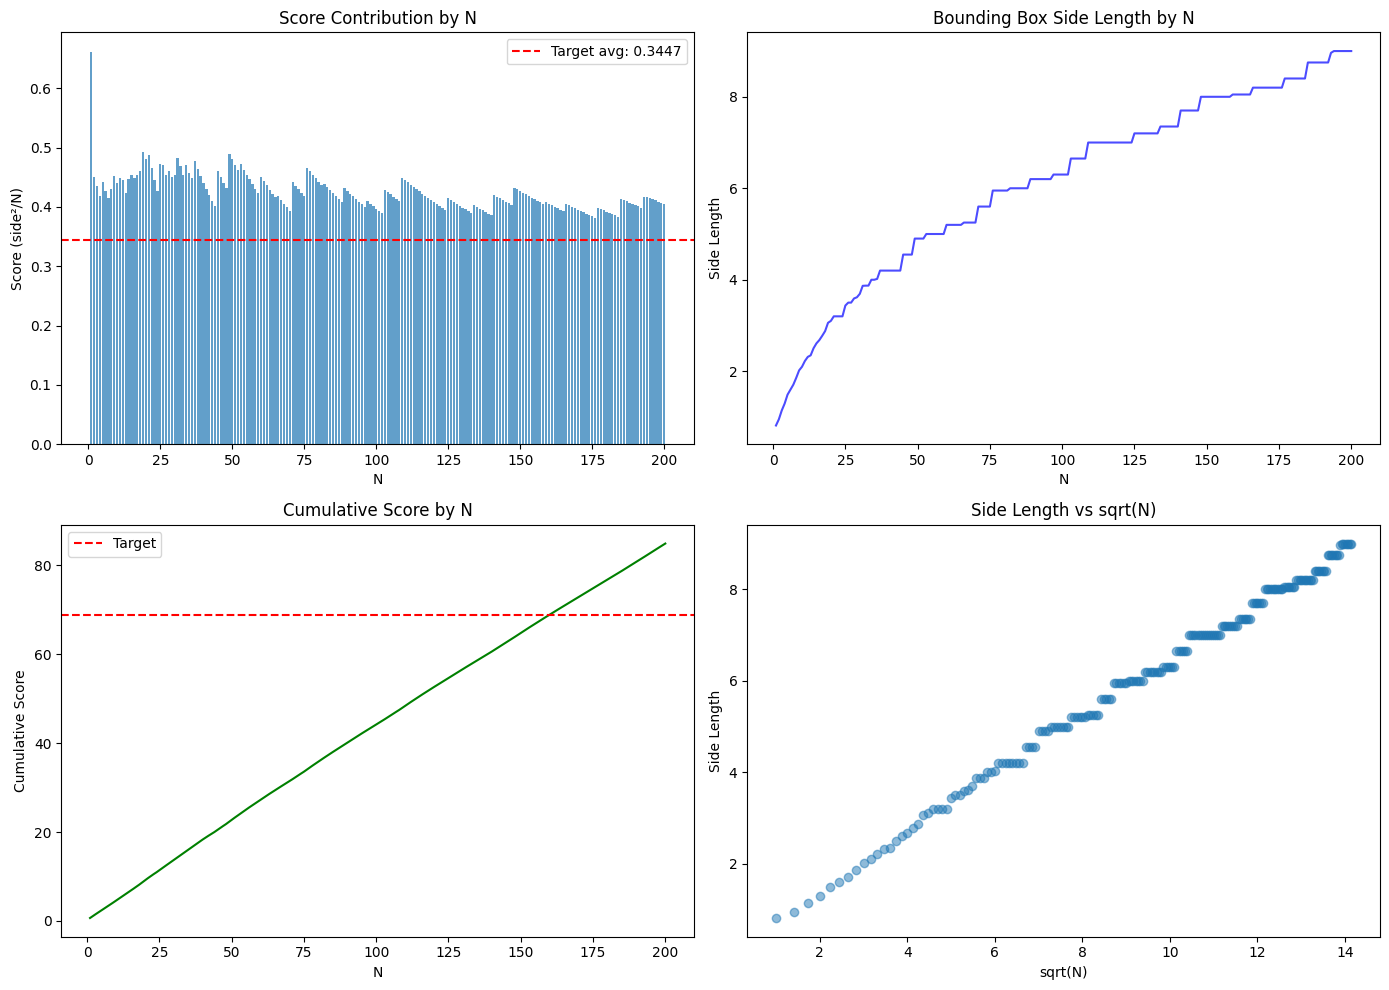

Saved analysis plot


In [4]:
# Visualize score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ax1.bar(scores_df['N'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (side²/N)')
ax1.set_title('Score Contribution by N')
ax1.axhline(y=68.931058/200, color='r', linestyle='--', label=f'Target avg: {68.931058/200:.4f}')
ax1.legend()

# Side length by N
ax2 = axes[0, 1]
ax2.plot(scores_df['N'], scores_df['side'], 'b-', alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')

# Cumulative score
ax3 = axes[1, 0]
scores_df['cumsum'] = scores_df['score'].cumsum()
ax3.plot(scores_df['N'], scores_df['cumsum'], 'g-')
ax3.axhline(y=68.931058, color='r', linestyle='--', label='Target')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')
ax3.legend()

# Score vs sqrt(N) - theoretical relationship
ax4 = axes[1, 1]
ax4.scatter(np.sqrt(scores_df['N']), scores_df['side'], alpha=0.5)
ax4.set_xlabel('sqrt(N)')
ax4.set_ylabel('Side Length')
ax4.set_title('Side Length vs sqrt(N)')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()
print('Saved analysis plot')

In [5]:
# Compare with theoretical optimal
# For N trees, theoretical minimum side ~ sqrt(N) * tree_width
# Tree width is approximately 0.7 (base width)

TREE_WIDTH = 0.7
TREE_HEIGHT = 1.0

theoretical = []
for n in range(1, 201):
    # Theoretical minimum: pack trees in a square grid
    # Side ~ sqrt(N) * tree_size
    # But trees can overlap slightly with rotation
    theoretical_side = np.sqrt(n) * TREE_WIDTH * 0.8  # 0.8 factor for packing efficiency
    theoretical_score = theoretical_side ** 2 / n
    theoretical.append({'N': n, 'theoretical_side': theoretical_side, 'theoretical_score': theoretical_score})

theoretical_df = pd.DataFrame(theoretical)

# Compare actual vs theoretical
comparison = scores_df.merge(theoretical_df, on='N')
comparison['efficiency'] = comparison['theoretical_side'] / comparison['side']
comparison['gap'] = comparison['score'] - comparison['theoretical_score']

print('Efficiency analysis (theoretical/actual side):')
print(f'Mean efficiency: {comparison["efficiency"].mean():.4f}')
print(f'Min efficiency: {comparison["efficiency"].min():.4f} at N={comparison.loc[comparison["efficiency"].idxmin(), "N"]}')
print(f'Max efficiency: {comparison["efficiency"].max():.4f} at N={comparison.loc[comparison["efficiency"].idxmax(), "N"]}')

# N values with worst efficiency (most room for improvement)
worst_efficiency = comparison.nsmallest(20, 'efficiency')
print('\nN values with worst packing efficiency (most room for improvement):')
print(worst_efficiency[['N', 'side', 'theoretical_side', 'efficiency', 'score', 'gap']].to_string(index=False))

Efficiency analysis (theoretical/actual side):
Mean efficiency: 0.8610
Min efficiency: 0.6887 at N=1
Max efficiency: 0.9060 at N=176

N values with worst packing efficiency (most room for improvement):
 N     side  theoretical_side  efficiency    score      gap
 1 0.813173          0.560000    0.688661 0.661250 0.347650
19 3.057855          2.440983    0.798266 0.492130 0.178530
49 4.900000          3.920000    0.800000 0.490000 0.176400
21 3.200000          2.566242    0.801951 0.487619 0.174019
31 3.867290          3.117948    0.806236 0.482449 0.168849
20 3.101126          2.504396    0.807576 0.480849 0.167249
50 4.900000          3.959798    0.808122 0.480200 0.166600
37 4.200000          3.406347    0.811035 0.476757 0.163157
25 3.435651          2.800000    0.814984 0.472148 0.158548
53 5.000000          4.076862    0.815372 0.471698 0.158098
26 3.500000          2.855451    0.815843 0.471154 0.157554
51 4.900000          3.999200    0.816163 0.470784 0.157184
34 4.000000       

In [6]:
# Check what optimization techniques are available
import os
import glob

print('Available kernels:')
for kernel_dir in glob.glob('/home/code/research/kernels/*/'):
    print(f'  - {os.path.basename(kernel_dir.rstrip("/"))}')

print('\nSnapshot solutions:')
for snap_dir in glob.glob('/home/nonroot/snapshots/santa-2025/*/'):
    print(f'  - {os.path.basename(snap_dir.rstrip("/"))}')

print('\nOur experiments:')
for exp_dir in glob.glob('/home/code/experiments/*/'):
    print(f'  - {os.path.basename(exp_dir.rstrip("/"))}')

# Check if bbox3 is available
bbox3_paths = glob.glob('/home/nonroot/snapshots/**/bbox3', recursive=True)
print(f'\nbbox3 binary found: {len(bbox3_paths) > 0}')
if bbox3_paths:
    print(f'  Path: {bbox3_paths[0]}')

Available kernels:
  - jonathanchan_santa25-ensemble-sa-fractional-translation
  - saspav_santa-submission
  - jazivxt_why-not
  - yongsukprasertsuk_santa-2025-best-keeping-bbox3-runner
  - smartmanoj_santa-claude
  - egortrushin_santa25-simulated-annealing-with-translations
  - inversion_santa-2025-getting-started
  - crodoc_74-75-backpacking-christmas-trees

Snapshot solutions:
  - 20992536951
  - 20971964134
  - 21086827828
  - 20992150197
  - 20991308120
  - 20970671503
  - 20952569566
  - 21016257921
  - 20984924920
  - 21090949260

Our experiments:
  - 001_baseline
  - 003_ensemble
  - 002_multiphase

bbox3 binary found: False


In [7]:
# Key insights summary
print('=' * 60)
print('KEY INSIGHTS FOR NEXT EXPERIMENT')
print('=' * 60)

print(f'\n1. CURRENT STATUS:')
print(f'   - Best score: {total_score:.6f}')
print(f'   - Target: 68.931058')
print(f'   - Gap: {total_score - 68.931058:.6f} ({(total_score - 68.931058) / 68.931058 * 100:.2f}%)')

print(f'\n2. WORST PERFORMING N VALUES:')
for _, row in worst_n.head(10).iterrows():
    print(f'   N={int(row["N"]):3d}: score={row["score"]:.6f}, side={row["side"]:.6f}')

print(f'\n3. OPTIMIZATION OPPORTUNITIES:')
print(f'   - Top 20 worst N values contribute {worst_n["score"].sum():.4f} ({worst_n["score"].sum() / total_score * 100:.2f}%)')
print(f'   - Average efficiency: {comparison["efficiency"].mean():.4f}')
print(f'   - If we improve worst 20 by 20%, we save: {worst_n["score"].sum() * 0.2:.4f} points')

print(f'\n4. TECHNIQUES NOT YET TRIED:')
print('   - bbox3 optimizer (3-hour budget approach)')
print('   - Translation-based initialization for grid-like N values')
print('   - Forward propagation (N=1 to N=200)')
print('   - Targeted optimization on worst N values')
print('   - Longer optimization runs (current: ~10 min, top kernels: 3 hours)')

KEY INSIGHTS FOR NEXT EXPERIMENT

1. CURRENT STATUS:
   - Best score: 84.894026
   - Target: 68.931058
   - Gap: 15.962968 (23.16%)

2. WORST PERFORMING N VALUES:
   N=  1: score=0.661250, side=0.813173
   N= 19: score=0.492130, side=3.057855
   N= 49: score=0.490000, side=4.900000
   N= 21: score=0.487619, side=3.200000
   N= 31: score=0.482449, side=3.867290
   N= 20: score=0.480849, side=3.101126
   N= 50: score=0.480200, side=4.900000
   N= 37: score=0.476757, side=4.200000
   N= 25: score=0.472148, side=3.435651
   N= 53: score=0.471698, side=5.000000

3. OPTIMIZATION OPPORTUNITIES:
   - Top 20 worst N values contribute 9.6565 (11.37%)
   - Average efficiency: 0.8610
   - If we improve worst 20 by 20%, we save: 1.9313 points

4. TECHNIQUES NOT YET TRIED:
   - bbox3 optimizer (3-hour budget approach)
   - Translation-based initialization for grid-like N values
   - Forward propagation (N=1 to N=200)
   - Targeted optimization on worst N values
   - Longer optimization runs (current